<a href="https://colab.research.google.com/github/aparna2004/KLA-Unhack/blob/main/Milestone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Method 1 - Image text detection (Using ocr)

###Installing Required Packages

####**Installing easyocr**
- Dependenciecs already available in colab

####**Downgrading to python-bidi 0.4.2**
- Because bidi.algorithm needed by easyocr not supported in higher versions

In [ ]:
!pip install easyocr --no-deps
!pip install python-bidi==0.4.2

### Speed limit detection using OCR
####**Libraries used**
- pandas -> data frame
- glob(function in python lib) -> To match image file paths
- easyocr -> Text detection using optical character recognition

####**Input**
- Images containing speed limit boards

####**Output**
- CSV file with two columns: Speed limit, Image Name

####**Function**
- detects text from images
- ignores words and takes only numbers
- if no number detecting - none
- returns sorted data(according to order of input) ignoring confidence and bounding box


In [6]:
import pandas as pd
from glob import glob
import easyocr

def speed_limit_detection(imgs, reader):
    dfs = []
    for img in imgs:
        detected_text = reader.readtext(img)
        img_id = img.split('/')[-1]

        if not detected_text:
            img_df = pd.DataFrame([{'bbox': None, 'Speed limit': 'None', 'conf': None, 'Image name': img_id}])
        else:
            img_df = pd.DataFrame(detected_text, columns=['bbox', 'Speed limit', 'conf'])
            img_df['Image name'] = img_id

        dfs.append(img_df)

    return pd.concat(dfs, ignore_index=True)

def main():

    reader = easyocr.Reader(['en'], gpu = True)
    images = glob('../content/sample_data/Milestone1/*')

    df = speed_limit_detection(images, reader)

    df = df[~df['Speed limit'].isin(['SPEED', 'LIMIT'])].drop(columns=['bbox','conf']).sort_values(by='Image name')
    df = df[['Image name', 'Speed limit']]

    df.to_csv('M1_Output.csv', index=False)

if __name__ == "__main__":
    main()

#Method 2 - Template matching (using open cv)

### Testing code
-To figure out which template matching method best suits this use case
####**Input**
- one image and one template image

####**Output**
- Image with template detected(denoted by a rectangle) in all methods


In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/Milestone1/Images/Picture5.jpg', 0)
template = cv2.imread('/content/Milestone1/Template/Template-80.jpg', 0)
h, w = template.shape

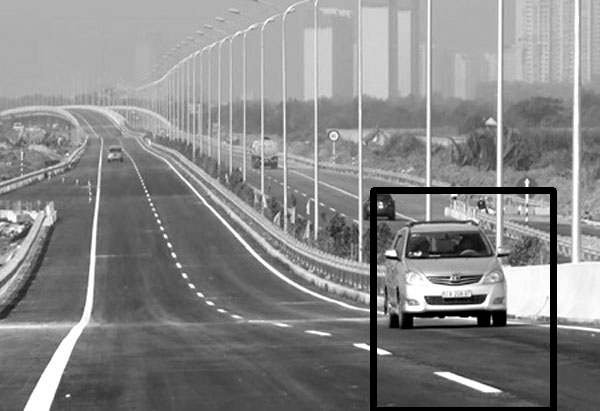

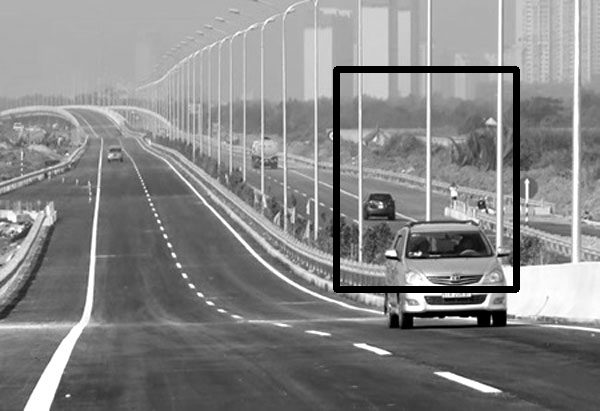

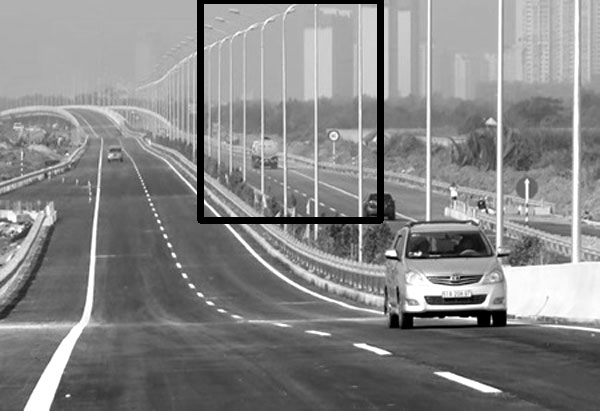

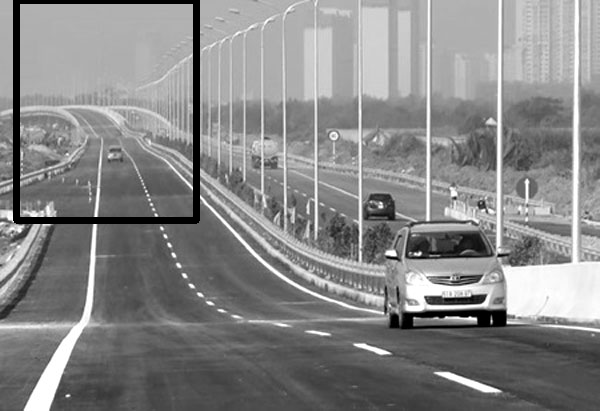

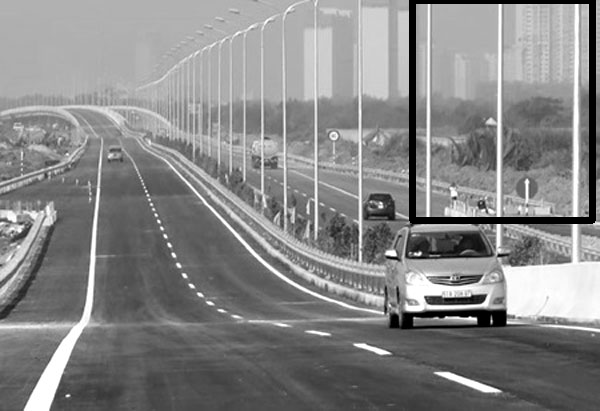

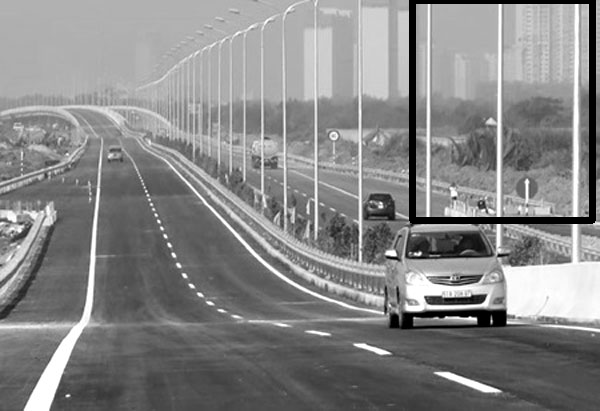

In [ ]:
methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
            cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]

for method in methods:
    img2 = img.copy()

    result = cv2.matchTemplate(img2, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        location = min_loc
    else:
        location = max_loc

    bottom_right = (location[0] + w, location[1] + h)
    cv2.rectangle(img2, location, bottom_right, 0, 5)
    cv2_imshow(img2) # cv2.imshow('Match', img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### Speed Detection - Using template matching

#### **Libraries Used**
- pandas -> DataFrames.
- glob -> Image paths
- cv2 -> image processing and template matching.
- re -> Regex

#### **Input**
- Images: Containing speed limit boards where template matching is applied.
- Templates: Template images used for matching against the main images.

####**Output**
- CSV File: With two columns: Image Name, Speed Limit

####**Functions**
- **extract_number(filename):** Extracts the number from the filename using regex.
- **speed_limit_detection(image_paths, template_paths, method, threshold):** Performs template matching on the list of images and templates, and returns the results as a DataFrame.


In [19]:
import numpy as np
import cv2
import pandas as pd
from glob import glob
import re

def extract_number(filename):
    """Extract the number from the filename."""
    match = re.search(r'-(\d+)', filename)
    return match.group(1) if match else None

def speed_limit_detection(image_paths, template_paths, method=cv2.TM_CCOEFF_NORMED, threshold=0.8):
    """Perform template matching on images and return results as a DataFrame."""
    results = []

    for img_path in image_paths:
        img = cv2.imread(img_path, 0)
        if img is not None:
            best_val = -np.inf
            best_template_number = None

            for template_path in template_paths:
                template = cv2.imread(template_path, 0)
                if template is not None:
                    h, w = template.shape
                    result = cv2.matchTemplate(img, template, method)
                    _, max_val, _, _ = cv2.minMaxLoc(result)

                    if max_val > best_val:
                        best_val = max_val
                        best_template_number = extract_number(template_path)

            if best_val >= threshold:
                results.append({
                    'Image name': img_path.split('/')[-1],
                    'Speed limit': best_template_number
                })
            else:
                results.append({
                    'Image name': img_path.split('/')[-1],
                    'Speed limit': 'None'
                })
        else:
            print(f"Error: Image '{img_path}' not found or unable to load.")

    df = pd.DataFrame(results).sort_values(by='Image name')
    return df

def main():

    image_paths = glob('/content/sample_data/Milestone1/*')
    template_paths = glob('/content/sample_data/Template/*')

    df = speed_limit_detection(image_paths, template_paths)

    df.to_csv('M1_Output.csv', index=False)

    print(df)

if __name__ == "__main__":
    main()


     Image name Speed limit
4  PICTURE1.PNG          45
2  Picture2.jpg          50
1  Picture3.jpg          85
0  Picture4.jpg          85
3  Picture5.jpg        None
